# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [ ]:
import torch
import torch.nn as nn
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from scipy.io import loadmat
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
num_points = 6
model = models.efficientnet_b7(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_points*2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 196MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
class DogHeartDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)

def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size=(resized_image_size, resized_image_size)))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

resized_image_size = 300
dataset_train = DogHeartDataset('/content/drive/MyDrive/Dog_Heart_VHS/Train', get_transform(resized_image_size))
data_loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_valid = DogHeartDataset('/content/drive/MyDrive/Dog_Heart_VHS/Valid', get_transform(resized_image_size))
data_loader_valid = DataLoader(dataset_valid, batch_size=8, shuffle=False)

class DogHeartTestDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.imgs[idx]

    def __len__(self):
        return len(self.imgs)

dataset_test = DogHeartTestDataset('/content/drive/MyDrive/Dog_Heart_VHS/Test/Images', get_transform(resized_image_size))
data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
criterion = torch.nn.MSELoss()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = data_loader_train
            else:
                model.eval()
                dataloader = data_loader_valid

            running_loss = 0.0

            for images, points, vhs in dataloader:
                images = images.to(device)
                points = points.to(device)
                vhs = vhs.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, points)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.7f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Loss: {best_loss:.7f}')

    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer)

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_efb7.pt')

Epoch 1/100
----------
train Loss: 0.0680017
val Loss: 0.0449346
Epoch 2/100
----------
train Loss: 0.0105646
val Loss: 0.0069704
Epoch 3/100
----------
train Loss: 0.0062623
val Loss: 0.0046045
Epoch 4/100
----------
train Loss: 0.0046141
val Loss: 0.0014859
Epoch 5/100
----------
train Loss: 0.0036985
val Loss: 0.0019584
Epoch 6/100
----------
train Loss: 0.0032343
val Loss: 0.0009747
Epoch 7/100
----------
train Loss: 0.0028599
val Loss: 0.0008465
Epoch 8/100
----------
train Loss: 0.0025733
val Loss: 0.0008743
Epoch 9/100
----------
train Loss: 0.0023382
val Loss: 0.0009232
Epoch 10/100
----------
train Loss: 0.0021832
val Loss: 0.0010510
Epoch 11/100
----------
train Loss: 0.0020803
val Loss: 0.0009874
Epoch 12/100
----------
train Loss: 0.0019365
val Loss: 0.0006330
Epoch 13/100
----------
train Loss: 0.0018209
val Loss: 0.0006080
Epoch 14/100
----------
train Loss: 0.0017168
val Loss: 0.0006058
Epoch 15/100
----------
train Loss: 0.0016561
val Loss: 0.0006687
Epoch 16/100
------

# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

In [ ]:
def v_h_s(points):
    A, B, C, D, E, F = points.reshape(6, 2)
    AB = np.linalg.norm(A - B)
    CD = np.linalg.norm(C - D)
    EF = np.linalg.norm(E - F)
    VHS = 6 * (AB + CD) / EF
    return VHS

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_efb7.pt'))
model.eval()

vhs_scores = []
filenames = []
with torch.no_grad():
    for images, img_filenames in data_loader_test:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.cpu().numpy()
        outputs = outputs.reshape(outputs.shape[0], 6, 2)
        for i, points in enumerate(outputs):
            w, h = Image.open(os.path.join('/content/drive/MyDrive/Dog_Heart_VHS/Test/Images/Images', img_filenames[i])).size
            points = points * resized_image_size
            points[:, 0] = w / resized_image_size * points[:, 0]
            points[:, 1] = h / resized_image_size * points[:, 1]
            vhs = v_h_s(points)
            vhs_scores.append(vhs)
            filenames.append(os.path.basename(img_filenames[i]))

df = pd.DataFrame({'filename': filenames, 'vhs_score': vhs_scores})
df.to_csv('vhs_scores.csv', index=False, header=False)

<ipython-input-9-f9e9e631eb3c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_efb7.pt'))


In [ ]:
checkpoint_path = '/content/drive/MyDrive/best_model_efb7.pt'
model.load_state_dict(torch.load(checkpoint_path))

<ipython-input-8-98b77ab5222d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


<All keys matched successfully>

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

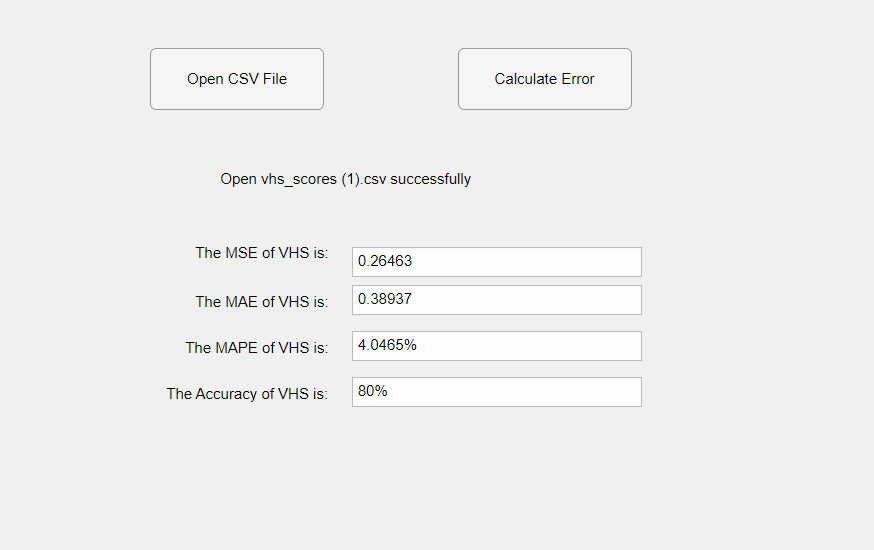

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

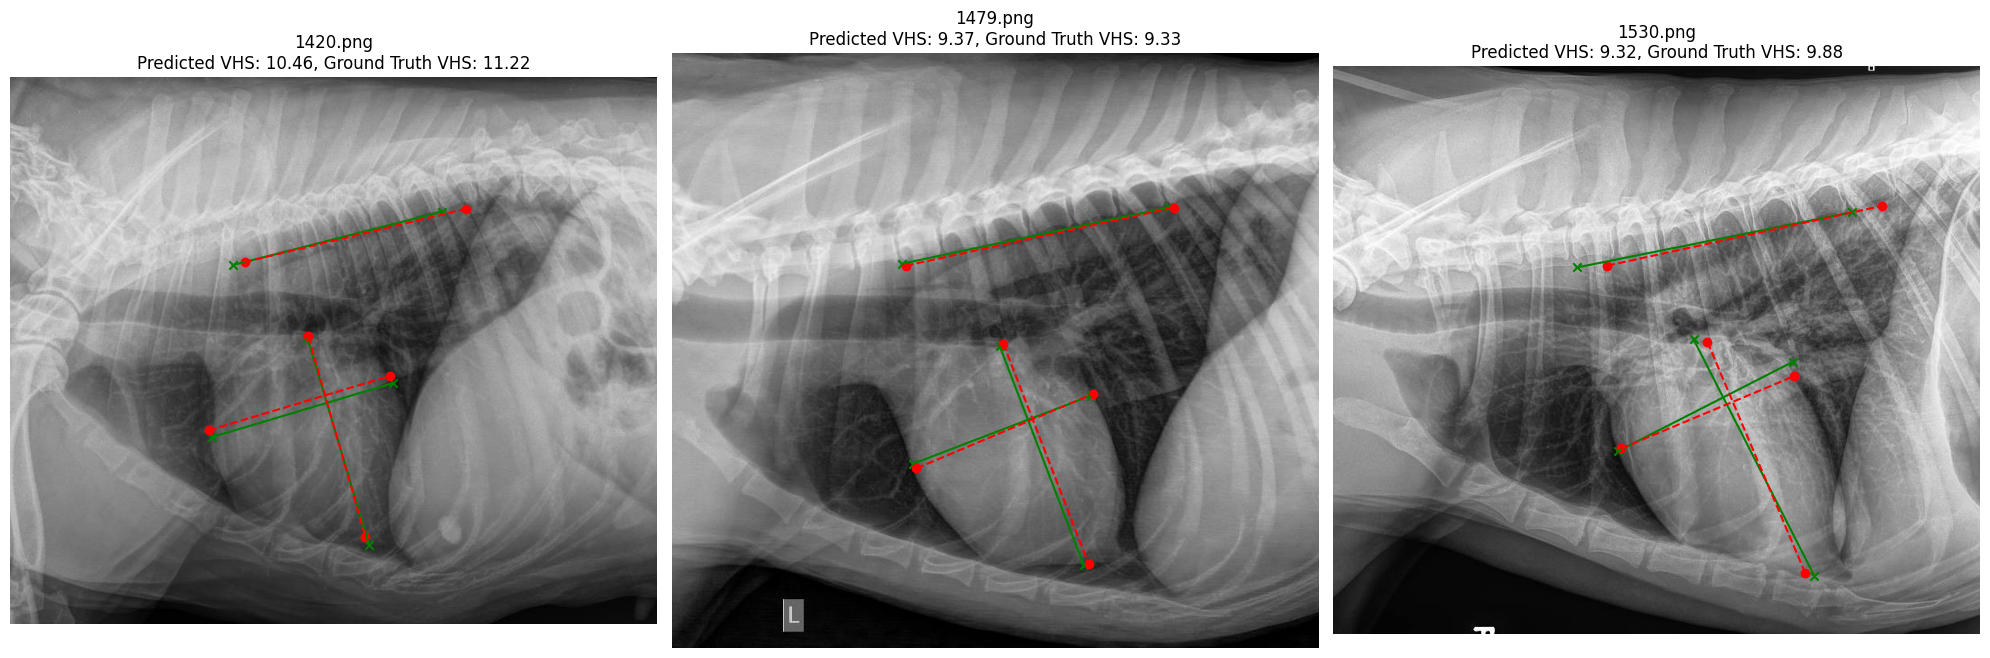

In [ ]:
def visualize_comparison(image_path, label_path, model, transform, device, ax):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    img_transformed = transform(img).unsqueeze(0).to(device)

    mat = loadmat(label_path)
    ground_truth_points = mat['six_points'].astype(float)
    ground_truth_vhs = mat['VHS'].astype(float).item()

    with torch.no_grad():
        pred_points = model(img_transformed).cpu().numpy().reshape(6, 2)
        pred_points = pred_points * resized_image_size
        pred_points[:, 0] = w / resized_image_size * pred_points[:, 0]
        pred_points[:, 1] = h / resized_image_size * pred_points[:, 1]
        pred_vhs = v_h_s(pred_points)

    ax.imshow(img)
    ax.scatter(ground_truth_points[:, 0], ground_truth_points[:, 1], c='green', marker='x', label='Ground Truth')
    ax.scatter(pred_points[:, 0], pred_points[:, 1], c='red', marker='o', label='Predicted')

    # ground truth points
    for (p1, p2) in [(0, 1), (2, 3), (4, 5)]:
        ax.plot([ground_truth_points[p1, 0], ground_truth_points[p2, 0]],
                [ground_truth_points[p1, 1], ground_truth_points[p2, 1]], 'g-')

    # predicted points
    for (p1, p2) in [(0, 1), (2, 3), (4, 5)]:
        ax.plot([pred_points[p1, 0], pred_points[p2, 0]],
                [pred_points[p1, 1], pred_points[p2, 1]], 'r--')

    ax.set_title(f"{os.path.basename(image_path)}\nPredicted VHS: {pred_vhs:.2f}, Ground Truth VHS: {ground_truth_vhs:.2f}")
    ax.axis('off')
    ax.set_aspect('equal')


image_names = ["1420.png", "1479.png", "1530.png"]
root_valid = '/content/drive/MyDrive/Dog_Heart_VHS/Valid'

fig, axs = plt.subplots(1, len(image_names), figsize=(20, 10))

for ax, image_name in zip(axs, image_names):
    image_path = os.path.join(root_valid, "Images", image_name)
    label_path = os.path.join(root_valid, "Labels", image_name.replace(".png", ".mat"))
    visualize_comparison(image_path, label_path, model, get_transform(resized_image_size=300), device, ax)

plt.tight_layout()
plt.show()

Predicted  results comparison. The green color lines are the ground truth lines and the red color lines are the predicted results.

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


Paper link: https://www.researchgate.net/publication/386425172_Deep_Learning-Based_Assessment_of_Canine_Cardiomegaly_via_Vertebral_Heart_Scale_Prediction

Csv file : https://drive.google.com/file/d/1UP4uBDCUxUkqBWD__Ydhp8W_kiH0CTFL/view?usp=drive_link

Pt file: https://drive.google.com/file/d/1yXa2GiMbGToF_TaQbNPpkeM6zyy3kGH2/view?usp=drive_link

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)